# Домашнее задание 3. Свёрточные и рекуррентные нейронные сети
## Ставропольцев Артём Викторович ИУ8-83

В зависимости от варианта, для решения задачи используйте следующие наборы данных:

<table>
    <thead>
         <tr>
            <th colspan=1>Задача генерации</th>
            <th colspan=5>Задача классификации</th>
        </tr>
        <tr>
            <th> </th>
            <th>A</th>
            <th>B</th>
            <th>C</th>
            <th>D</th>
            <th>E</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>K</td>
            <td>1</td>
            <td>2</td>
            <td>3</td>
            <td>4</td>
            <td>5</td>
        </tr>
        <tr>
            <td>L</td>
            <td>6</td>
            <td>7</td>
            <td>8</td>
            <td>9</td>
            <td>10</td>
        </tr>
        <tr>
            <td>M</td>
            <td>11</td>
            <td>12</td>
            <td>13</td>
            <td>14</td>
            <td>15</td>
        </tr>
        <tr>
            <td>N</td>
            <td>16</td>
            <td>17</td>
            <td>18</td>
            <td>19</td>
            <td>20</td>
        </tr>
        <tr>
            <td>O</td>
            <td>21</td>
            <td>22</td>
            <td>23</td>
            <td>24</td>
            <td>25</td>
        </tr>
    </tbody>
</table>

### Наборы данных

**Задача классификации картинок**

B. [Набор данных "Текстуры"](https://pytorch.org/vision/main/generated/torchvision.datasets.DTD.html#torchvision.datasets.DTD) `torchvision.datasets.DTD split='train' и 'test'`

---

**Задача генерации текстов**

M. [Набор данных "Стихи"]() `stihi.csv`

# 0. Инициализация библиотек

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imgaug as ia
from imgaug import augmenters as iaa
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from collections import Counter
from torch.nn import functional as F

# 1. Свёрточная нейронная сеть для классификации изображений (9 баллов)

## 1.1 Загрузка данных, разделение на train и test

Загрузите данные при помощи torchvision.datasets. Можете предусмотреть опредлённые транфсофрмации картинки, например, изменение размера до 128 px, кроп по центру в 196 px и преобразование к классу torch.Tensor:

```
import torchvision


transform = torchvision.transforms.Compose([
    # resize
    torchvision.transforms.Resize(128),
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.ToTensor()
])
```

In [2]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

train_data = datasets.DTD('data',split = 'train', download=True, transform=transform)
test_data = datasets.DTD('data',split = 'test', download=True, transform=transform)
classes = train_data.classes

In [3]:
SEED = 1000
np.random.seed(SEED)
ia.seed(SEED)
torch.manual_seed(SEED)

pd.set_option("display.max_columns", None)

BATCH=128

In [4]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=False
)

## 1.2 Предобработка данных (по необходимости)

## 1.3 Инициализация объекта свёрточной нейронной сети

Создайте нейронную сеть с 2-4 свёрточными слоями. В остальном конфигурация сети может быть произвольной. 

In [5]:
class Network1(nn.Module):
  def __init__(self):
    super(Network1, self).__init__()
    self.nureal_network = nn.Sequential()
    self.nureal_network.add_module('c1', nn.Conv2d(3, 32, kernel_size = 3, padding = 1))
    self.nureal_network.add_module('a1', nn.ReLU())
    self.nureal_network.add_module('p1', nn.MaxPool2d(2,2))
    self.nureal_network.add_module('c2', nn.Conv2d(32, 64, kernel_size = 3, padding = 1))
    self.nureal_network.add_module('a2', nn.ReLU())
    self.nureal_network.add_module('p2', nn.MaxPool2d(2,2))
    self.nureal_network.add_module('c3', nn.Conv2d(64, 128, kernel_size = 3, padding = 1))
    self.nureal_network.add_module('a3', nn.ReLU())
    self.nureal_network.add_module('p3', nn.MaxPool2d(2,2))
    
    self.nureal_network.add_module('f1', nn.Flatten())
    self.nureal_network.add_module('l1', nn.Linear(16*16*128, 2048))
    self.nureal_network.add_module('a4', nn.ReLU())
    self.nureal_network.add_module('l2', nn.Linear(2048, 1024))
    self.nureal_network.add_module('a5', nn.ReLU())
    self.nureal_network.add_module('l3', nn.Linear(1024, 47))

  def forward(self,x):
    return self.nureal_network(x)

## 1.4 Обучение сввёрточной нейронной сети для решения задачи классификации

In [34]:
def train(model, optimizer, train_dataloader, test_dataloader):
  criterion = nn.CrossEntropyLoss().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

  result = dict()
  result['train_loss'] = list()
  result['test_loss'] = list()
  result['train_acc'] = list()
  result['test_acc'] = list()

  for epoch in range(35):
    model = model.train()
    train_loss_list = list()
    test_loss_list = list()
    train_acc = 0
    test_acc = 0
    for data_batch, result_batch in train_dataloader:
      optimizer.zero_grad()
      data_batch = data_batch.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
      result_batch = result_batch.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
      prediction = model(data_batch)
      loss = criterion(prediction, result_batch)
      loss.backward()
      optimizer.step()
      train_loss_list.append(loss.item())
      predicted = torch.max(prediction.data, 1)[1]
      train_acc += torch.sum(result_batch==predicted).item()
    result['train_loss'].append(np.mean(train_loss_list))
    result['train_acc'].append(100.* train_acc/len(train_dataloader.dataset))

    with torch.no_grad():
      for data_batch, result_batch in test_dataloader:
        data_batch = data_batch.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        result_batch = result_batch.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        prediction = model(data_batch)
        loss = criterion(prediction, result_batch)
        test_loss_list.append(loss.item())
        predicted = torch.max(prediction.data, 1)[1]
        test_acc += torch.sum(result_batch==predicted).item()
    result['test_loss'].append(np.mean(test_loss_list))
    result['test_acc'].append(100.* test_acc/len(test_dataloader.dataset))

  return model.eval(), result

In [35]:
test_model = Network1().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
opt=torch.optim.Adam(test_model.parameters(), lr=0.001)

In [36]:
test_model, history = train(test_model, opt, train_loader, test_loader)

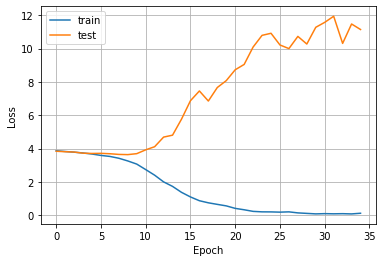

In [37]:
figure = plt.figure().gca()
figure.plot(history['train_loss'])
figure.plot(history['test_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.grid()
plt.show()

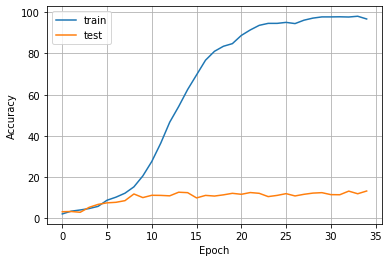

In [38]:
figure = plt.figure().gca()
figure.plot(history['train_acc'])
figure.plot(history['test_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.grid()
plt.show()

## 1.5 Агументация данных и регулряизации нейросети

Попобуйте добавить аугументацию (случайные повороты, увеличение, уменьшение) в данные, а также регуляризацию (Drop out и Batch Norm слои) в модель. Как меняется метрика accuracy на обучающей и тестовой выборке в процессе обучения? Постройте график.

In [39]:
class Network2(nn.Module): # добавила в предыдущую модель по одному Dropout и BatchNorm
  def __init__(self):
    super(Network2, self).__init__()
    self.nureal_network = nn.Sequential()
    self.nureal_network.add_module('c1', nn.Conv2d(3, 32, kernel_size = 3, padding = 1))
    self.nureal_network.add_module('a1', nn.ReLU())
    self.nureal_network.add_module('p1', nn.MaxPool2d(2,2))
    self.nureal_network.add_module('d1', nn.Dropout2d(0.2))
    self.nureal_network.add_module('c2', nn.Conv2d(32, 64, kernel_size = 3, padding = 1))
    self.nureal_network.add_module('b1', nn.BatchNorm2d(64))
    self.nureal_network.add_module('a2', nn.ReLU())
    self.nureal_network.add_module('p2', nn.MaxPool2d(2,2))
    self.nureal_network.add_module('c3', nn.Conv2d(64, 128, kernel_size = 3, padding = 1))
    self.nureal_network.add_module('a3', nn.ReLU())
    self.nureal_network.add_module('p3', nn.MaxPool2d(2,2))
    
    self.nureal_network.add_module('f1', nn.Flatten())
    self.nureal_network.add_module('l1', nn.Linear(16*16*128, 2048))
    self.nureal_network.add_module('d2', nn.Dropout(0.2))
    self.nureal_network.add_module('a4', nn.ReLU())
    self.nureal_network.add_module('l2', nn.Linear(2048, 1024))
    self.nureal_network.add_module('b2', nn.BatchNorm1d(1024))
    self.nureal_network.add_module('a5', nn.ReLU())
    self.nureal_network.add_module('l3', nn.Linear(1024, 47))

  def forward(self,x):
    return self.nureal_network(x)

In [40]:
transform_aug = transforms.Compose([
    transforms.RandomApply(transforms=[transforms.RandomInvert(),
                                       transforms.RandomRotation(30),
                                       transforms.ColorJitter(brightness=0.5, hue=0.2)], p=0.6),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

In [41]:
train_data_aug = datasets.DTD('data',split = 'train', download=True, transform=transform_aug)
test_data_aug = datasets.DTD('data',split = 'test', download=True, transform=transform_aug)
classes_aug = datasets.DTD('data',split = 'train', download=True, transform=transform_aug).classes

In [42]:
train_loader_aug = DataLoader(
    train_data_aug,
    batch_size=BATCH,
    shuffle=True
)

test_loader_aug = DataLoader(
    test_data_aug,
    batch_size=BATCH,
    shuffle=False
)

## 1.6 Обучение нейросети на данных с аугументацией 

In [43]:
test_model_aug = Network2().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
opt_aug=torch.optim.Adam(test_model_aug.parameters(), lr=0.001)
test_model_aug, history_aug = train(test_model_aug, opt_aug, train_loader_aug, test_loader_aug)

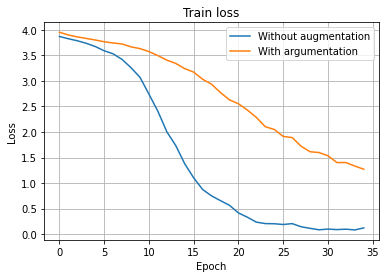

In [44]:
figure = plt.figure().gca()
figure.plot(history['train_loss'])
figure.plot(history_aug['train_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Without augmentation', 'With argumentation'])
plt.title('Train loss')
plt.grid()
plt.show()

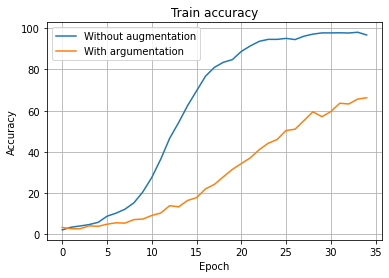

In [45]:
figure = plt.figure().gca()
figure.plot(history['train_acc'])
figure.plot(history_aug['train_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Without augmentation', 'With argumentation'])
plt.title('Train accuracy')
plt.grid()
plt.show()

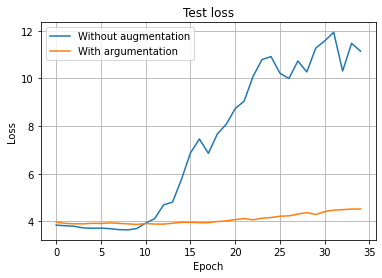

In [46]:
figure = plt.figure().gca()
figure.plot(history['test_loss'])
figure.plot(history_aug['test_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Without augmentation', 'With argumentation'])
plt.title('Test loss')
plt.grid()
plt.show()

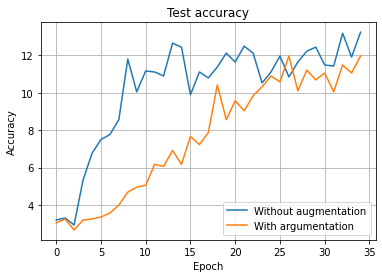

In [47]:
figure = plt.figure().gca()
figure.plot(history['test_acc'])
figure.plot(history_aug['test_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Without augmentation', 'With argumentation'])
plt.title('Test accuracy')
plt.grid()
plt.show()

In [48]:
print('Без аугментацией')
print(f"Train loss: {round(min(history['train_loss']), 5)}")
print(f"Test  loss: {round(min(history['test_loss']), 5)}")
print(f"Train acc:  {round(max(history['train_acc']), 5)}")
print(f"Test  acc:  {round(max(history['test_acc']), 5)}")

Без аугментацией
Train loss: 0.08209
Test  loss: 3.63839
Train acc:  98.08511
Test  acc:  13.24468


In [49]:
print('C аугментацией')
print(f"Train loss: {round(min(history_aug['train_loss']), 5)}")
print(f"Test  loss: {round(min(history_aug['test_loss']), 5)}")
print(f"Train acc:  {round(max(history_aug['train_acc']), 5)}")
print(f"Test  acc:  {round(max(history_aug['test_acc']), 5)}")

C аугментацией
Train loss: 1.27071
Test  loss: 3.86779
Train acc:  66.2766
Test  acc:  11.96809


## 1.7 Выводы

Что удалось попробовать? Что получилось, а что — нет? Повлияло ли добавление аугументации на качество?

После добавление аугментации данных точность предсказания немного упала.
Нейросеть с регулряизацией дает более точные предсказания, что немного нивелировало аугументацию данных.

# 2. Рекуррентная нейронная сеть для генерации текстов (9 баллов)

## 2.1 Загрузка данных



In [9]:
df = pd.read_csv('./data/M_stihi.csv')

In [10]:
df

,author,text
0,Марина Копсергенова,\r\nДетки мои Живите неспеша чтоб пела ...
1,Владислав Иванов 13,Каждый по своему проводит свою ночь\r\nКто спи...
2,Лия Эль,Нежно так я словами касался предплечий\r\nИх ...
3,Елена Кедровая Шишка,Ты как всегда меня поймешь\r\nИ как всегда ...
4,Леонид Хегай,Укусить бы кого нибудь больно\r\nиль повыть п...
...,...,...
164438,Кирилл Кузнечихин,пародия на дворовые романсы\r\nВаши ножки чуд...
164439,Владислав Никоненко,Не надо нагло нарушать\r\nЗаконы Мойте руки\r...
164440,Наталья Потапенко 2,Магда нравится Так что же здесь странного\r\n...
164441,Фатима Дадаева,Нам пустоту рождает пустота\r\nИ голова нужна ...


## 2.2 Преодбработка/нормализация данных по необходимости

Например, можно привести все слова к нижнему регистру

In [11]:
text_data = str()
for i in range(len(df)):
  verse = str(df['text'][i]).lower()
  lines = verse.split("\r\n")
  for i in range(len(lines)):
    lines[i] = " ".join(lines[i].split())
  verse = "\r\n".join(lines)
  text_data += verse + "\r\n"

text_data = text_data[2:]

In [12]:
char_counter = Counter(text_data)
char_counter = sorted(char_counter.items(),
                      key = lambda ch: ch[1],
                      reverse = True)
char_map =  {j[0]: i for i, j in enumerate(char_counter)}
index_map = {j: i for i, j in char_map.items()}
text_data_code = np.array([char_map[i] for i in text_data])
len(text_data_code)

95159436

## 2.3 Инициализация объекта рекуррентной нейронной сети

In [13]:
class NetworkRNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size, layers_count):
        super(NetworkRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.layers_count = layers_count

        self.embeding = nn.Embedding(self.input_size, self.embedding_size)
        self.rnn = nn.RNN(self.embedding_size, self.hidden_size, self.layers_count)
        self.dropout = nn.Dropout(0.2)

        self.linear1=nn.Linear(self.hidden_size,self.hidden_size//2)
        self.linear2=nn.Linear(self.hidden_size//2, self.hidden_size//4)
        self.linear3=nn.Linear(self.hidden_size//4, self.input_size)
        
    def forward(self, x, h):
        x = self.embeding(x).squeeze(2)
        x, h = self.rnn(x, h)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x, h
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.layers_count, batch_size, self.hidden_size, requires_grad=False).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

## 2.4 Обучение обычной рекуррентной нейронной сети

In [14]:
def get_batch(batch_size=20, length=250):
    x = list()
    y = list()

    for _ in range(20):
        rand_i = np.random.randint(0, len(text_data_code) - 250)
        x_i = torch.LongTensor(text_data_code[rand_i:rand_i + 250 - 1])
        x.append(x_i.view(-1, 1))
        y_i = torch.LongTensor(text_data_code[rand_i + 1:rand_i + 250])
        y.append(y_i.view(-1, 1))

    x = torch.stack(x, dim=0).permute(1, 0, 2).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    y = torch.stack(y, dim=0).permute(1, 0, 2).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return x, y

In [15]:
def eval(model, start, length, temp):
    x = torch.LongTensor([char_map[char] for char in start]).view(-1, 1, 1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(1)
        _, hidden = model.forward(x, hidden)
        x = x[-1].view(-1, 1, 1)
        for _ in range(length):
            y, hidden = model.forward(x, hidden)
            y = y.cpu().data.view(-1)
            prop = torch.nn.functional.softmax(y / temp, dim=-1).detach().cpu().data.numpy()
            index = np.random.choice(len(char_map), p=prop)
            start += index_map[index]
            x = torch.LongTensor([index]).view(-1, 1, 1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return start

In [16]:
def train(model, optimizer):
  criterion = torch.nn.CrossEntropyLoss()
  train_loss = list()

  for epoch in range(20000):
    model.train()
    optimizer.zero_grad()
    x, y = get_batch()
    x = x.permute(1, 0, 2).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    y = y.permute(1, 0, 2).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    h = model.init_hidden(249)

    prediction, _ = model.forward(x, h)
    loss = criterion(prediction.permute(1, 2, 0), y.squeeze(-1).permute(1, 0))
    train_loss.append(loss.item())
    loss.backward()
    optimizer.step()

  return train_loss

In [17]:
networkRNN=NetworkRNN(len(char_map), 128, 256, 3).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = torch.optim.Adam(networkRNN.parameters(), lr=0.001, amsgrad=True)
loss_rnn = train(networkRNN, optimizer)

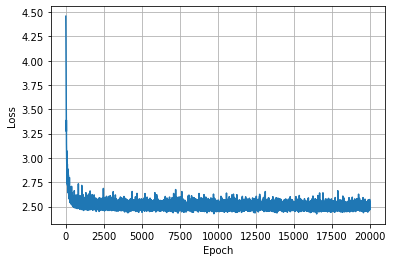

In [18]:
figure = plt.figure().gca()
figure.plot(loss_rnn)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

## 2.5 Генерация текстов при помощи обычной рекуррентной сети

In [19]:
for temp_i in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    pred_text = eval(networkRNN, "нежно так я словами касался предплечий", 500, temp_i)
    print(f"Temp={temp_i}: {pred_text}")
    print()

Temp=0.1: нежно так я словами касался предплечий не не во сто не ст сто не во сто во не но ст сто не ве не по по по в не ст по в во в во сто про в сто по не в сто ве сто сто в по сто не по сто сто сто по сто сто по не во не не не в во по но сто во ве сто сто по на не по и сто не сто не в сто не по по в не сто в не сто сто по сто по во не сто по не сто в не сто но но по в сто во не в не не по ве ве не сто не не сто в но не но не по в в сто сто в сто сто во сто в по сто не по ве в не по во пра во во сто по в не по сто в в на по не по в по то не

Temp=0.2: нежно так я словами касался предплечий сто по на про не по ни се по и в сто по стов ве не по на в сть по сто по не не про ве сто ве по сто на ве ва не сто в сто нона пра сто по но не в в ва за пра и поть по м сто ве по по по пово но про по м во не по в по то в сто во по во ве не во по вора в во сто в по во сть по на но по ста ве по во не во сто не по в не сто не на ни не в сто в по в по в не по в по не на сто по по по по про то по в не 

## 2.6 Обучение рекуррентной нейронной сети с LSTM-ячейками

In [20]:
class NetworkLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size, layers_count):
        super(NetworkLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.layers_count = layers_count

        self.embeding = nn.Embedding(self.input_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.layers_count)
        self.dropout = nn.Dropout(0.2)

        self.linear1=nn.Linear(self.hidden_size,self.hidden_size//2)
        self.linear2=nn.Linear(self.hidden_size//2, self.hidden_size//4)
        self.linear3=nn.Linear(self.hidden_size//4, self.input_size)
        
    def forward(self, x, h):
        x = self.embeding(x).squeeze(2)
        x, (h, c) = self.lstm(x, h)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x, (h, c)
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.layers_count, batch_size, self.hidden_size, requires_grad=False).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        c = torch.zeros(self.layers_count, batch_size, self.hidden_size, requires_grad=False).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        return (h, c)

In [21]:
networkLSTM=NetworkLSTM(len(char_map), 128, 256, 3).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = torch.optim.Adam(networkLSTM.parameters(), lr=0.01, amsgrad=True)
loss_lstm = train(networkLSTM, optimizer)

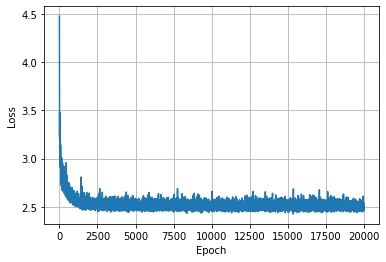

In [22]:
figure = plt.figure().gca()
figure.plot(loss_lstm)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()

## 2.7 Генерация текстов с разной температурой

Попробуйте сгенерировать тексты с температурой из списка: `[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]` (см. нотубук с семинара по RNN)

In [23]:
for temp_i in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    pred_text = eval(networkLSTM, "нежно так я словами касался предплечий", 500, temp_i)
    print(f"Temp={temp_i}: {pred_text}")
    print()

Temp=0.1: нежно так я словами касался предплечий в на сто по сто сто но ве т ве ни в в сто не не не в сто в ве сто в сто по ве ве на не в сто не не по сть по не сто сто на по не сто сто на ве не в сто в сто ва сто ве ве во сто ве по сто сто ве ве сто во сто ве в сто по сто в на на в в сто сто ве ве в сто на сто ве в в сто в не не не сто по сто на сто по в ве по то на не сто по не сто сто ве ве сть сто сто в сто в ве по не не сть сто по по сто ве сто в в сто по не в в сто на в то ве ст не в в на сто на всто сто сто сто по ве на не во в в на не

Temp=0.2: нежно так я словами касался предплечий сто пра в по но сто во по по по сто не ве по м в сть сто ве в сто во пра сто в не про про то сть ст по в не по про на да по но ста по ве не не сто по в и по сто в по не по не по по не ст по пра по на по но на в на на на сто ве то в стов по не сто в но ве ве сто ве ве всто ве на сть ва по то ве ве во сть не в ст сто то на в не на во ве по ва м то не сто пра ст но по в по на т ве по ста ве всто в по 

## 2.8 Выводы

RNN обучалась ~30 минут, LSTM ~1 час. Результаты генерации и у LSTM и у RNN не очень удовлетворительные, однако явно видно, что LSTM выдает более лучший результат: на графике loss снижается интенсивнее, текст получился более осмысленным.
Возможно, увеличение количества слоев, количества обучающей выборки улучшит качество генерации.